## Surface Observation Data Screening
#### Karl Lapo, October/2015
### Test robustness of station data -- visual QC
1) Current daily data ('grobs.daily.nc')
    - no additional QC or screening
    - run through EOFs to check for consistency between stations
2) Qsi anomalies and EOF/PC analysis (removing annual cycle)
    - anomaly relative to all ground observations (shown, more interesting eof signal)
    - anomaly relative to individual group (very small signal)
3) Load hourly data
    - throw out days with bad night time QC
    - require 80% of day time obs to be present to make daily average

#### Questions
    - How much data do I lose?
    - How does it compare to the original data set?
    - Do EOF patterns change?
    
#### Test robustness of station data -- visual QC
    - Remove smj, station behaves radically differently than other stations
    - Encouragingly robust behavior across groups
    


In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
import xray
import pandas as pd
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from datetime import datetime, timedelta
import pytz
import kray #### Custom functions for manipulating xray structures

# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Solargeometry
import solargeo

# OS interaction
import sys
import os

In [2]:
#### Directory Lists
# General directories
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_grobs = '/GroundObs'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

# Individual data directories
dir_cv_cimis_ucipm = '/Users/karllapo/gdrive/GroundObs/CA_CentralValley.UCDavis/RAW/CIMIS/UCDavis_IPM.Daily'
dir_cv_cimis = '/Users/karllapo/gdrive/GroundObs/CA_CentralValley.UCDavis/RAW/CIMIS/CIMIS.Hourly'
dir_sio_cdwr = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/GroundObs/YOS.SIO.Obs'

In [3]:
#### Flags
FLAG_EOF = 0 # Run EOF analysis (computationally expensive!)

In [4]:
#############################################################################################
## Functions
#############################################################################################

In [5]:
from scipy import interpolate as interp
from scipy.stats.stats import pearsonr
from scipy import stats

#### Function for creating anomalies
def anom(ds_in):
    def extrap1d(interpolator):
    ## Helper function for creating extrapolated values (linear)
    # http://stackoverflow.com/questions/2745329/...
    # ...how-to-make-scipy-interpolate-give-an-extrapolated-result-beyond-the-input-range
        from scipy import array
        xs = interpolator.x
        ys = interpolator.y

        def pointwise(x):
            if x < xs[0]:
                return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
            elif x > xs[-1]:
                return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
            else:
                return interpolator(x)

        def ufunclike(xs):
            return array(map(pointwise, array(xs)))

        return ufunclike

    # Time averaging -- monthly averaging
    # Monthly mean composite
    comp_mean = ds_in.groupby('time.month').mean(dim='time').mean(dim='station')

    ## Daily, mean anomaly -- interpolate monthly composite
    # Daily composite mean calculated from interpolation of monthly composite mean
    comp_mean_daily = xray.Dataset()
    # Julian day of month mid point for non-leap year. Force the function to be cyclic
    x_month = np.array([0,15.5, 45, 74.5, 105, 135.5, 166, 196.5, 227.5, 258, 288.5, 319, 349.5,365])

    # Daily anomaly for each group
    y = comp_mean.values
    y_cyclic = np.mean([y[0],y[-1]])
    y = np.insert(y,0,y_cyclic)
    y = np.append(y,y_cyclic)
    # Interpolation function of monthly composite
    daily_interp_f = interp.interp1d(x_month,y)
    # Linear extrapolation for beginning and end of year
    daily_interp_f = extrap1d(daily_interp_f)

    # Assign to structure
    comp_mean_daily = xray.Dataset()
    x_day = ds_in['time.dayofyear'].values
    comp_mean_daily['doy_mean'] = (('dayofyear'),daily_interp_f(x_day))
    
    comp_mean_daily = xray.Dataset({'doy_mean': (['time'],  daily_interp_f(x_day))},\
                                    coords={'time': (ds_in['time']),\
                                    'dayofyear': x_day})
    # Fill out coords
#     comp_mean_daily.coords['time'] = ('dayofyear',ds_in['time'])
#     comp_mean_daily = comp_mean_daily.swap_dims({'dayofyear':'time'})
    ds_anom = ds_in - comp_mean_daily
    return(ds_anom)

In [6]:
##### Iterative eof 
def naneof_BR2003(X):
    Xfunc = np.copy(X)
    if np.abs(np.nanmean(Xfunc)) > .001:
        # Remove nanmean of data
        dat_mean = np.nanmean(Xfunc)
        Xfunc[~np.isnan(Xfunc)] = Xfunc[~np.isnan(Xfunc)]-dat_mean
    else:
        dat_mean = 0
    ## Subset of data for validation, remove nans
    X0 = np.copy(Xfunc)
    idok_r,idok_c = np.nonzero(~np.isnan(Xfunc)) 
    id_val_r = idok_r[np.ceil(np.random.uniform(size=(np.floor(idok_r.shape[0]/50)))* \
                              idok_r.shape[0]).astype(int)-1] # validation subset (rows)
    id_val_c = idok_c[np.ceil(np.random.uniform(size=(np.floor(idok_c.shape[0]/50)))* \
                              idok_c.shape[0]).astype(int)-1] # validation subset (columns)
    
    X_val = Xfunc[id_val_r,id_val_c]
    mx_val = np.nansum(np.nansum(X_val**2))
    
    # remove validation subset from the data
    Xfunc[id_val_r,id_val_c] = np.nan;
    # Update index of non-nans
    idok_r,idok_c = np.nonzero(~np.isnan(Xfunc))
    # replace NaNs by zeros
    Xfunc[np.isnan(Xfunc)] = 0
    
    ## find out how many eigenfunctions to retain...
    Nit = 100
    tol = 1e-8
    err = np.empty(min(Xfunc.shape[1],20))*np.nan
    for Ne in np.arange(1,min(Xfunc.shape[1],20)):
        X1 = np.copy(Xfunc)
        for k in np.arange(2,Nit):
            # compute SVD (equivalent of economy method in matlab)
            U,D,V = np.linalg.svd(X1,full_matrices=False)
    
            # truncate and estimate "interpolated" D
            N = Ne
            Ut = U[:,0:N]
            Dt = D[0:N]
            Vt = V[0:N,:]
            Xa = np.dot(np.dot(Ut,np.diag(Dt)),Vt)
            Xa[idok_r,idok_c] = Xfunc[idok_r,idok_c] # restore real data
            X2 = np.copy(Xa)
    
            # termination criterium?
            dx=np.nansum((X2-X1)**2,axis=1)
            dx=dx[:,np.newaxis]
            mx=np.nansum(X2**2,axis=1)
            mx=mx[:,np.newaxis]
            dxex = np.linalg.lstsq(dx.T,mx.T)
            dxex = dxex[-1]
            if dxex < tol:
                print('Converged in '+str(k-1)+' iterations to the tolerance of '+str(tol))
                break
            X1 = np.copy(X2)
    
        # error?
        Xa = np.dot(np.dot(Ut,np.diag(Dt)),Vt)
        dx_val = np.nansum(np.nansum((Xa[id_val_r,id_val_c]-X_val)**2))
        err[Ne] = dx_val/mx_val
    
    ## Loop through again using the optimal number of eigenvalues only
    Nopt = np.flatnonzero(err == np.nanmin(err))
    
    X1 = np.copy(X0);
    # Subset of data for validation
    idok_r,idok_c = np.nonzero(~np.isnan(X1)) 
    X1[np.isnan(X1)] = 0
    for k in np.arange(2,Nit):
        # compute SVD (equivalent of economy method in matlab)
        U,D,V = np.linalg.svd(X1,full_matrices=False)#     N = Nopt;
        # truncate and estimate "interpolated" D
        N = Nopt
        Ut = U[:,0:N]
        Dt = D[0:N]
        Vt = V[0:N,:]
        Xa = np.dot(np.dot(Ut,np.diag(Dt)),Vt)
        Xa[idok_r,idok_c] = Xfunc[idok_r,idok_c] # restore real data
        X2 = np.copy(Xa)
        
        # termination criterium?
        dx=np.nansum((X2-X1)**2,axis=1)
        dx=dx[:,np.newaxis]
        mx=np.nansum(X2**2,axis=1)
        mx=mx[:,np.newaxis]
        dxex = np.linalg.lstsq(dx.T,mx.T)
        dxex = dxex[-1]
        if dxex < tol:
            print('Converged in '+str(k-1)+' iterations to the tolerance of '+str(tol))
            break
        X1 = np.copy(X2)
        
    # units in B
    B = np.dot(U,np.diag(D))  #the temporal modes
    amps = V # the spatial modes
    #the variance of the original temperature series
    orig_var = np.nanmean(X0**2) 
    #divide by the product of the original matrix size and by the variance
    variance = D**2/orig_var*100/(X0.shape[0]*X0.shape[1])
    
    return(B,amps,variance,dat_mean,Nopt,U,V,D)

In [7]:
##########################
## Part 1) Current Data ##
##########################
## Load data
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')

## Slice only for the period with the majority of stations
grobs = grobs.sel(time=slice('2007-10-01','2012-10-01'))

In [8]:
## Iterative eofs
if FLAG_EOF:
    B,amps,variance,dat_mean,Nopt,U,V,D = naneof_BR2003(grobs.grobs.values)

In [9]:
if FLAG_EOF:
    ## Plot Results
    fig,axes = plt.subplots(1,6,figsize=(15,3))
    axes[0].plot(np.arange(1,11),variance[0:10],'-o')
    axes[0].set_title('eof variance explained')
    axes[0].set_ylabel('variance')
    axes[0].set_xlabel('eof #')

    ## Basemap of spatial patterns (EOFs) -- Entire study domain
    lon_stat = grobs.longitude.values
    lat_stat = grobs.latitude.values
    bmp,bmd = kgraph.build_basemap(lon_stat,lat_stat,dir_bmap,'CA.Domain.bmp.pickle')
    lat_labels = np.arange(34,42,2)
    lon_labels = np.arange(-116.,-124.,-2)

    ## Basemap of spatial patterns (EOFs) -- Mountain region
    # lat = np.array((36,38.1))
    # lon = np.array((-120.2,-117.5))
    # bmp,bmd = kgraph.build_basemap(lon,lat,dir_bmap,'CAMnt.Domain.bmp.pickle')
    # lat_labels = np.arange(36,39,.5)
    # lon_labels = np.arange(-120,-117,1)

    # Discrete colormap
    # cmap_delta = cmap_discretize(cm.RdBu_r,11)

    for n in np.arange(0,5):
        ax = axes[n+1]
        im = bmp.scatter(lon_stat,lat_stat,c=amps[n,:],s=75, linewidths=.25,latlon=True,\
                         ax=ax,cmap=cm.RdBu_r,vmin=-.5,vmax=.5)
        ax.set_title('eof coef '+str(n+1))

        ## Format
        if n == 0:
            bmp.drawparallels(lat_labels,labels=[1,0,0,0],ax=ax)
        else:
            bmp.drawparallels(lat_labels,ax=ax)
        bmp.drawmeridians(lon_labels,labels=[0,0,0,1],ax=ax) 

        # Colorbar
        if n == 2:
            cb = bmp.colorbar(im,"right", size="5%", pad='2%')
            cb.set_label('EOF (?)', fontsize=12)  

##### Result
    - Most of the data are described by the annual cycle (all dim and brighten at the same time
    - Other bizarre features that are barely relevant

In [10]:
###############################
## Part 2) Daily Tau Anomaly ##
###############################
## Load data
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')

## Slice only for the period with the majority of stations
grobs = grobs.sel(time=slice('2007-10-01','2012-10-01'))

## Transmissivity
tau = grobs.grobs/(np.sin(grobs.el*np.pi/180)*1365)

In [11]:
## Tau anomaly
tau_anom = anom(tau)

## Qsi anomaly
qsi_anom = anom(grobs.grobs)
print(qsi_anom)

<xray.Dataset>
Dimensions:    (dayofyear: 1828, station: 70, time: 1828)
Coordinates:
  * dayofyear  (dayofyear) int32 274 275 276 277 278 279 280 281 282 283 284 ...
  * time       (time) datetime64[ns] 2007-10-01 2007-10-02 2007-10-03 ...
  * station    (station) |S19 'Alpaugh' 'ARVIN' 'Auburn' 'bee' 'BISHOP' ...
    network    (station) |S9 'CIMIS_IPM' 'CIMIS_IPM' 'CIMIS_IPM' 'CDWR' ...
    elev       (station) float64 64.0 152.0 285.0 2.768e+03 1.271e+03 215.0 ...
    latitude   (station) float64 35.87 35.2 38.88 37.53 37.35 35.65 37.93 ...
    longitude  (station) float64 -119.5 -118.8 -121.1 -118.3 -118.4 -120.0 ...
    Grouping   (station) |S13 'south cv' 'foothills' 'foothills' ...
Data variables:
    doy_mean   (time, station) float64 4.942 5.942 -9.058 48.41 29.94 3.942 ...


In [12]:
if FLAG_EOF:
    ## Iterative eofs
    B,amps,variance,dat_mean,Nopt,U,V,D = naneof_BR2003(tau_anom.doy_mean.values)

In [13]:
if FLAG_EOF:
    ## Plot Results
    fig,axes = plt.subplots(1,6,figsize=(15,3))
    axes[0].plot(np.arange(1,11),variance[0:10],'-o')
    axes[0].set_title('eof variance explained')
    axes[0].set_ylabel('variance')
    axes[0].set_xlabel('eof #')

    ## Basemap of spatial patterns -- entire domain
    lon_stat = grobs.longitude.values
    lat_stat = grobs.latitude.values
    bmp,bmd = kgraph.build_basemap(lon_stat,lat_stat,dir_bmap,'CA.Domain.bmp.pickle')
    lat_labels = np.arange(34,42,2)
    lon_labels = np.arange(-116.,-124.,-2)

    ## Basemap of spatial patterns -- mountain stations
    # lat = np.array((36,38.1))
    # lon = np.array((-120.2,-117.5))
    # bmp,bmd = kgraph.build_basemap(lon,lat,dir_bmap,'CAMnt.Domain.bmp.pickle')
    # lat_labels = np.arange(36,39,.5)
    # lon_labels = np.arange(-120,-117,1)

    # Discrete colormap
    # cmap_delta = cmap_discretize(cm.RdBu_r,11)

    for n in np.arange(0,5):
        ax = axes[n+1]
        im = bmp.scatter(lon_stat,lat_stat,c=amps[n,:],s=75, linewidths=.25,latlon=True,\
                         ax=ax,cmap=cm.RdBu_r,vmin=-.5,vmax=.5)
        ax.set_title('eof coef '+str(n+1))

        ## Format
        if n == 0:
            bmp.drawparallels(lat_labels,labels=[1,0,0,0],ax=ax)
        else:
            bmp.drawparallels(lat_labels,ax=ax)
        bmp.drawmeridians(lon_labels,labels=[0,0,0,1],ax=ax) 

        # Colorbar
        if n == 2:
            cb = bmp.colorbar(im,"right", size="5%", pad='2%')
            cb.set_label('EOF (?)', fontsize=12)  

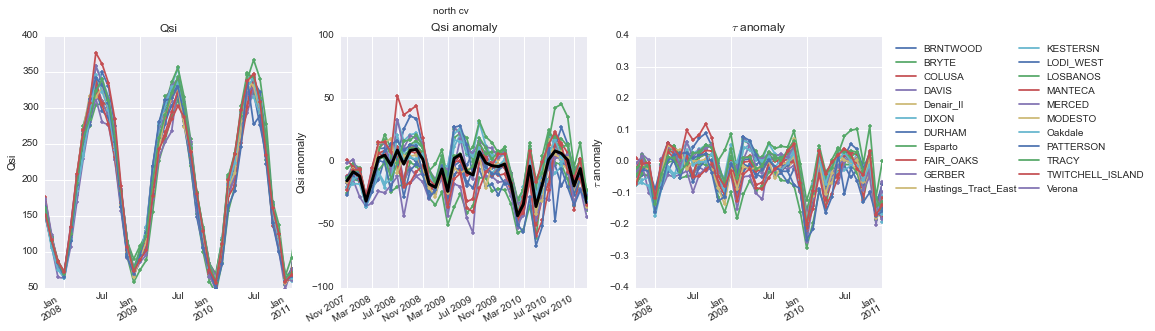

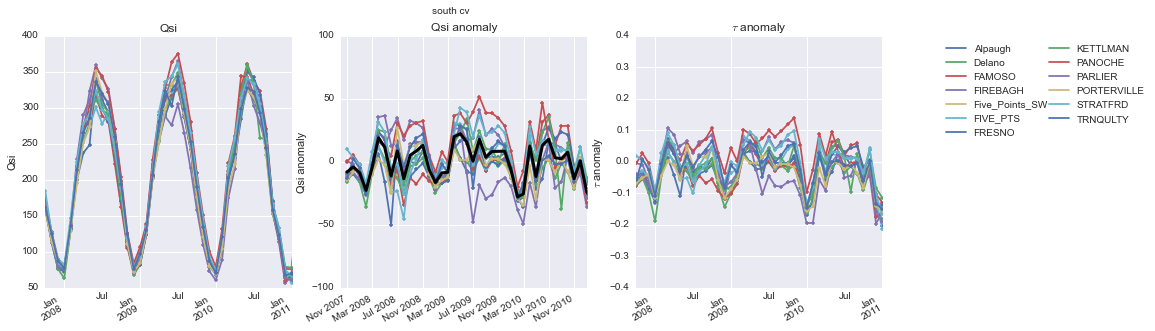

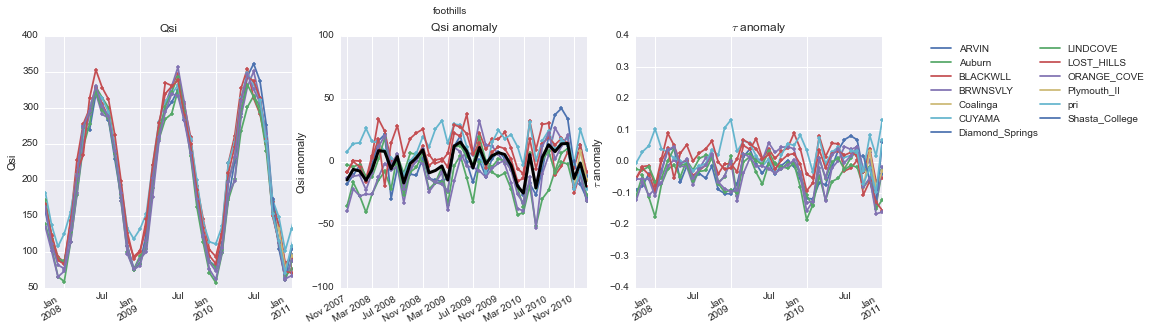

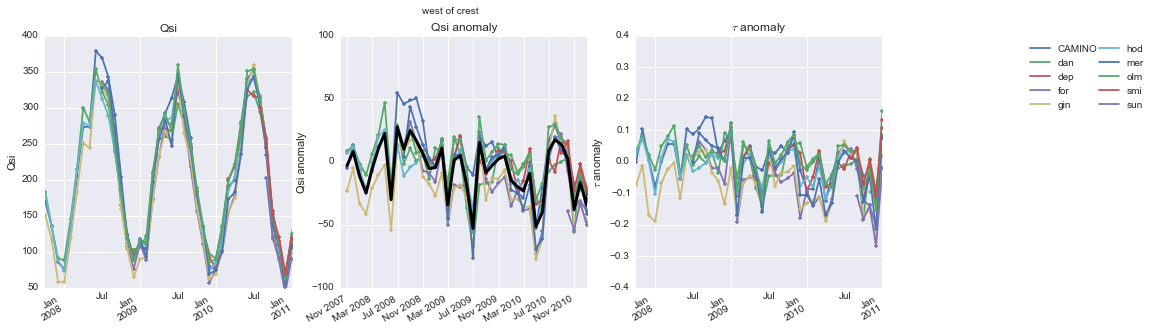

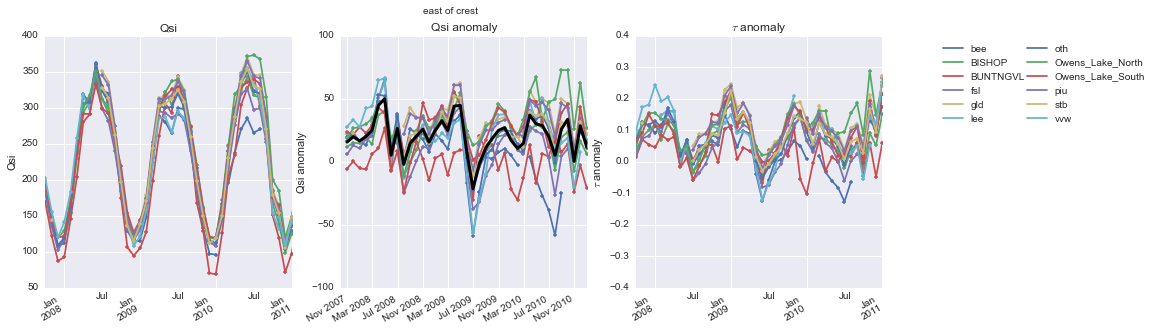

In [14]:
## Identifying individual stations that seem to be behaving differently
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
for n,gr in enumerate(grouping):
    fig,axes = plt.subplots(1,3,figsize=(15,5))
    
    ## Qsi
    ax = axes[0]
    grobs.grobs.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
            swap_dims({'Grouping':'station'}).resample(freq='M',dim='time',how='mean').to_pandas().\
            plot(marker='.',ax=ax)
    ax.set_xlim(datetime(2007,10,1),datetime(2011,1,1))
    ax.set_title('Qsi')
    ax.set_xlabel('')
    leg = ax.legend()
    leg.remove()
    ax.set_ylim(50,400)
    ax.set_ylabel('Qsi')
    
    ## Qsi anomaly
    ax = axes[1]
    ax.plot(qsi_anom.resample(freq='M',dim='time',how='mean').time,\
            qsi_anom.doy_mean.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
            mean(dim='Grouping').resample(freq='M',dim='time',how='mean'),\
           'k',lw=3,zorder=20)
    qsi_anom.doy_mean.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
            swap_dims({'Grouping':'station'}).resample(freq='M',dim='time',how='mean').to_pandas().\
            plot(marker='.',ax=ax)
    ax.set_xlim(datetime(2007,10,1),datetime(2011,1,1))
    ax.set_title('Qsi anomaly')
    ax.set_xlabel('')
    leg = ax.legend()
    leg.remove()
    ax.set_ylim(-100,100)
    ax.set_ylabel('Qsi anomaly')

    ## Tau anomaly
    ax = axes[2]
    tau_anom.doy_mean.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
            swap_dims({'Grouping':'station'}).resample(freq='M',dim='time',how='mean').to_pandas().\
            plot(marker='.',ax=ax)
    ax.set_xlim(datetime(2007,10,1),datetime(2011,1,1))
    ax.set_title('$\\tau$ anomaly')
    ax.set_xlabel('')
    ax.legend(ncol=2,loc='upper right',bbox_to_anchor=(1.6, .5, .5, .5),\
              columnspacing=.25,markerscale=.1,scatterpoints=0)
    ax.set_ylim(-.4,.4)
    ax.set_ylabel('$\\tau$ anomaly')
    
    fig.suptitle(gr)
    fig.autofmt_xdate()


##### Results:
- smj station is out to lunch compared to typical spread within groups
- Some stations occasionally behave very differently than the group, but only for limited periods

north cv mean std in Qsi: 19 Wm-2
south cv mean std in Qsi: 17 Wm-2
foothills mean std in Qsi: 24 Wm-2
west of crest mean std in Qsi: 28 Wm-2
east of crest mean std in Qsi: 27 Wm-2


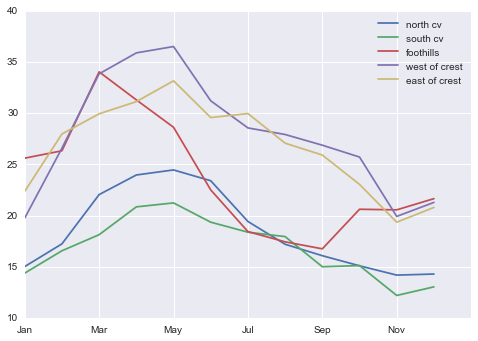

In [15]:
## Mean spread in Qsi across groups
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for gr in grouping:
    print(gr+' mean std in Qsi: '+\
            str(int(grobs.grobs.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
            std(dim='Grouping').mean(dim='time').values.round()))+\
            ' Wm-2')

    plt.plot(grobs.grobs.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].\
        std(dim='Grouping').groupby('time.month').mean(dim='time'),label=gr)
    plt.axes().set_xticklabels(month_label[::2])
    plt.legend()

##### Results:
- Typical uncertainty within groups is 18-27 Wm-2, supporting my (slightly optimistic) statement that the observational uncertainty is 20Wm-2 on longer timescales.
- Ignoring west of crest due to the influence of 'smj' station
- From this I am going to adjust the uncertainty to $<abs(20Wm^{-2})$ for valley stations and $<abs(30Wm^{-2})$ for mountain stations
- Uncertainty has seasonality (peaking in the spring, shrinking into the summer), compare this to the seasonal bias